In [ ]:
comments = pd.DataFrame(columns = ['Date','user_id','comments'])


In [ ]:
import copy
comments_copy = copy.deepcopy(comments)

In [ ]:
comments_copy.to_csv('comments.csv', header=True)

In [4]:
from time import sleep
from selenium import webdriver
from string import punctuation
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import copy
import matplotlib.pyplot as plt
%pylab inline
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/Users/alexmcgraw/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [105]:
import pandas as pd
original = pd.read_csv('comments.csv')
brand_original = pd.read_csv('car models and brands.csv', header=None, names = ['brand','model'])
text = (original).dropna()
brand = (brand_original)
text = text.reset_index(drop = True).drop(['Unnamed: 0'], axis =1)

In [106]:
from string import punctuation

def removepunc(item):
    for p in punctuation:
        item = item.strip().replace(p,'')
    return item

def lowerize(x):
    return x.lower()

text['comments_clean'] = text['comments'].apply(removepunc).apply(lowerize)
brand = brand.applymap(removepunc).applymap(lowerize)

In [49]:
brand

,brand
model,
integra,acura
legend,acura
vigor,acura
rlx,acura
ilx,acura
mdx,acura
rdx,acura
tsx,acura
rsx,acura


In [9]:
"""text['comments_clean'] = ' ' + text['comments_clean'] + ' '

def model_to_brand(s):
    for i in brand.index.values:
        s = s.replace(' ' + brand["model"][i] + ' ', ' ' + brand["brand"][i] + ' ').strip()
    return s
text['comments_model_replace'] = text['comments_clean'].apply(model_to_brand)
"""

In [107]:
brand.set_index('model', inplace=True)
text['comments_model_replace'] = text['comments_clean'].replace(to_replace=brand.index, value=brand['brand'], regex=True)

In [108]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

text['comments_tokenized'] = text['comments_model_replace'].apply(word_tokenize).apply(set).apply(list)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alexmcgraw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [109]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
def remove_stopwords(s):
    return [w for w in s if w not in stop_words]
text['comments_final'] = text['comments_tokenized'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexmcgraw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [110]:
count = []
for i in range(len(text)):
    count += text['comments_final'][i]
    

In [111]:
from nltk import FreqDist
word_freq = nltk.FreqDist(count)


In [112]:
unique_brands = brand['brand'].drop_duplicates().tolist()


In [134]:
top_words = word_freq.most_common(500)


In [114]:
top_brands = {}
for (key, items) in top_words:
    if key in unique_brands:
        top_brands[key] = items


Task A: Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations between the brands. You will have to write a script to do this task). For lift calculations, be sure not to count a mention more than once per post, even if it is mentioned multiple times in the post.
Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available online). 


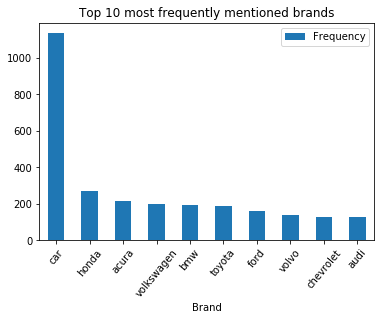

In [115]:
top_brands_df = pd.DataFrame(top_brands.items(), columns=['Brand', 'Frequency'])
top_brands_df[:10].plot.bar(x="Brand", y="Frequency", rot = 50, title="Top 10 most frequently mentioned brands")

In [116]:
top_10_brands = top_brands_df['Brand'][:10]

In [117]:
def brand_mentioned(s):
    d = []
    for item in s:
        if item in unique_brands:
            d.append(item)
    return d
text['brand_mentioned'] = text['comments_final'].apply(brand_mentioned)

In [118]:
n = len(text)
def combo_count(a,b):
    tally = 0
    for i in range(n):
        if a in text['brand_mentioned'].iloc[i] and b in text['brand_mentioned'].iloc[i]:
            tally += 1
    return tally

In [119]:
matrix = pd.DataFrame(index=top_10_brands, columns=top_10_brands)
for a in top_10_brands:
    for b in top_10_brands:
        if a == b:
            matrix.loc[a,b] = np.nan
        else:
            matrix.loc[a,b] = combo_count(a,b) * n / (top_brands[a] * top_brands[b])

#matrix.loc['honda']['acura'] -= 3
#matrix.loc['acura']['honda'] -= 3
matrix

Brand,car,honda,acura,volkswagen,bmw,toyota,ford,volvo,chevrolet,audi
Brand,,,,,,,,,,
car,NaN,1.67548,1.62518,1.32699,1.477,1.11367,1.30308,1.46943,1.11075,1.50442
honda,1.67548,NaN,4.50537,2.25875,1.61645,2.42717,0.696094,1.20303,1.30723,1.02481
acura,1.62518,4.50537,NaN,1.64549,1.42496,0.969973,1.30397,2.83787,0.362785,1.09699
volkswagen,1.32699,2.25875,1.64549,NaN,0.788818,2.28204,0.481228,2.03302,1.80745,2.63148
bmw,1.477,1.61645,1.42496,0.788818,NaN,2.5768,0.810316,1.12035,0.811592,2.04508
toyota,1.11367,2.42717,0.969973,2.28204,2.5768,NaN,1.3238,0.762624,2.6932,2.50576
ford,1.30308,0.696094,1.30397,0.481228,0.810316,1.3238,NaN,0.683484,2.72317,0.499052
volvo,1.46943,1.20303,2.83787,2.03302,1.12035,0.762624,0.683484,NaN,1.14093,2.01248
chevrolet,1.11075,1.30723,0.362785,1.80745,0.811592,2.6932,2.72317,1.14093,NaN,0.624797


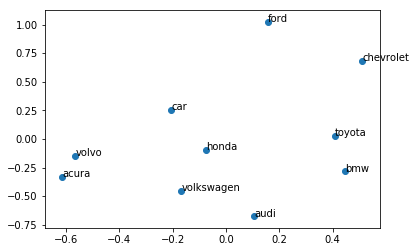

In [120]:
#MDS
from sklearn import manifold

mds_matrix = 1/matrix
mds_matrix = mds_matrix.fillna(0)
mds = manifold.MDS(n_components=2, dissimilarity='precomputed', random_state=1, max_iter=3000)
result = mds.fit(mds_matrix)
pos = result.embedding_
X = pos[:,0]
Y = pos[:,1]
plt.scatter(X,Y)
for i, txt in enumerate(mds_matrix.index):
    plt.annotate(txt, (X[i], Y[i]))
plt.show()

Task B: What insights can you offer brand managers from your analysis in Task A (choose two brands that you can offer the most interesting/useful insights for)? 

Task C: What are 5 most frequently mentioned attributes of cars in the discussions? Which attributes are most strongly associated with which of these 5 brands? You DON’T have to do a sentiment analysis for this assignment.

In [121]:
freq = pd.DataFrame(top_words, columns = ['word', 'frequency'])
freq.to_csv('word_freq_final.csv')

In [122]:
attributes = { 
    
    'Performance': ['pick-up', 'accelaration', 'drive', 'engine', 'sport', 'driving', 'performance', 'power', 'speed', 
                     'fast', 'faster', 'sporty', 'horsepower', 'powerful'],
    
    'Consumption': ['consumption','mile', 'mileage', 'oil', 'diesel', 'mpg', 'gas', 'fuel', 'leak'],
    
    'Look': ['look', 'appearance', 'looking', 'design', 'style', 'attractive', 'designed', 'looked'],
    
    'Luxury': [ 'luxury', 'premium','luxurious'],
    
    'Reliability': ['issue', 'recall', 'trouble', 'concerned', 'suspension', 'reliable',
                   'service', 'warranty', 'durability', 'durance','quality', 'durable'],
    
    'Price': ['value', 'cost', 'money', 'msrp', 'price', 'sale', 'offer', 'discount', 'bargain', 'grand', 'expensive',
             'cheap', 'cheaper', 'incentive', 'worth'],

    'Exterior': ['headlights', 'dents', 'scratches', 'paint job', 'door'],

    'Interior': ['seat', 'interior', 'leather', 'steering', 'inside', 'radio', 'noise', 'quiet', 'air conditioner',
                'heater', 'dashboard', 'cabin'],

    'Experience': ['experience', 'special', 'interesting', 'impressive', 'surprised', 'amazing', 
                   'fun', 'happy', 'bad'],
    
    'Safety': ['safety', 'life', 'safe', 'braking', 'seatbelt', 'airbags', 'collision' ]
}

top_5_brand = top_brands_df['Brand'][:5]
top_5_brand

0           car
1         honda
2         acura
3    volkswagen
4           bmw
Name: Brand, dtype: object

In [123]:
def word_to_attribute(s):
    att = []
    for word in s:
        for key, item in attributes.items():
            if word in item:
                att.append(key)
    return list(set(att))
text['attributes']=text['comments_final'].apply(word_to_attribute)

In [124]:
attribute_count = text['attributes'].sum()
att_freq = nltk.FreqDist(attribute_count)
top_5_att = att_freq.most_common(5)
top_5_att_dict = {}
for (key, items) in top_5_att:
    top_5_att_dict[key] = items
top_5_att_list = list(top_5_att_dict.keys())

In [125]:
def att_brand(a,b):
    tally = 0
    for i in range(n):
        if a in text['brand_mentioned'].iloc[i] and b in text['attributes'].iloc[i]:
            tally += 1
    return tally

In [126]:
att_matrix = pd.DataFrame(index=top_5_brand, columns=top_5_att_dict.keys())
for a in top_5_brand:
    for b in top_5_att_dict.keys():
        att_matrix.loc[a,b] = att_brand(a,b) * n / (top_brands[a] * top_5_att_dict[b])
att_matrix

,Price,Performance,Look,Experience,Reliability
Brand,,,,,
car,1.62983,1.63802,1.41723,1.56193,1.66268
honda,1.79702,2.54932,1.53994,1.95745,1.73937
acura,2.02789,2.13249,1.55489,1.74019,2.00072
volkswagen,1.82607,2.1947,1.90269,2.52299,2.02522
bmw,1.3005,2.08294,1.87654,1.25133,1.85428


Task D: What advice will you give to a (i) product manager, and (ii) marketing/advertising manager of these brands based on your analysis in Task C? For this assignment, you can assume the sentiment (e.g., that it is positive). 

Task E: Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?

In [131]:
aspirations = pd.read_csv('car models and brands with aspirations.csv')
aspirations = aspirations[-21:]
aspirations = aspirations.rename(columns={'acura': 'wish', 'integra': 'aspire'})
aspirations.set_index('wish', inplace=True)
print(aspirations)

text['comments_final'].replace(to_replace = aspirations.index, value = aspirations['aspire'], regex=True)


                         aspire
wish                           
want to own          aspiration
wish to own          aspiration
want to drive        aspiration
want to buy          aspiration
wish I could         aspiration
wish I had           aspiration
If I could           aspiration
Should have bought   aspiration
should have got      aspiration
would love           aspiration
would enjoy driving  aspiration
would enjoy buying   aspiration
desire to own        aspiration
desire to buy        aspiration
love to have         aspiration
love to drive        aspiration
love to own          aspiration
yearn to drive       aspiration
yearn to own         aspiration
long to buy          aspiration
eager to drive       aspiration


0                            [never, ’, nerves, category]
1       [nj, breld, force, combine, could, achieve, cr...
2                                 [proud, nothing, rusty]
3       [executing, plan, offers, lease, time, order, ...
4       [watching, flatbed, old, hauled, also, romanti...
5       [covid, philly, director, south, lease, mazda,...
6       [accounting, firm, repeated, losses, regtoyota...
7                                     [thinking, forward]
8                                               [awkward]
9       [wouldnt, wed, advantages, llc, wonder, let, g...
10            [long, yeah, fleet, done, point, set, time]
11                               [long, months, 10, time]
12                                          [breld, done]
13      [name, believe, maturity, breld, thy, actually...
14      [fleet, good, else, start, nothing, itd, 10, m...
15      [l, supra, left, exit, make, thanksgiving, tak...
16      [submitted, odometer, back, id, title, ’, revi...
17      [sprin

In [128]:
count = []
for i in range(len(text)):
    count += text['comments_final'][i]

In [133]:
from nltk import FreqDist
word_freq = nltk.FreqDist(count)
word_freq['car']

1134